In this Notebook, we prepare the Proximus data into a usable mobility matrix at the level of postal codes, municipalities, arrondissements and provinces.

- Question: how should we interpret the foreigners that go abroad? The current matrix for December 21st says that there are roughly 200k people that come from abroad and go abroad. What does that mean?
- Question: how should we handle the -1 values? Is there a clever way to go about?
    - Add 0
    - Add some value between 0 and 30 (such as 10)
    - Add a random value between 0 and 30 every time
    - Extrapolate the actual value from the values at all previous days: if for some days the value goes above 30, the average value is expected to be close to 30 as well, whilst the opposite is true if the value is _always_ at -1.
- Question: how should we handle multiple visits per day (i.e. people coming from place A, visiting place B and C, and returning to place A)
- Question: the raw data is not a square matrix, so some postal codes are missing. This is not an issue after aggregation into municipalities
- Problem: Herstappe (PC 3717, NIS 73028) is not in the data (only 88 inhabitants). How to handle this?
- Question: _our_ list of postal codes is 1147 PCs long. The Internet claims there are 1169 PCs in Belgium (including special PCs for e.g. military bases). We stick with the 1147?
- Problem: There is no data for a number of small PC regions, such as Herstappe (PC 3717)
- Question: what is considered a *visit*? In corona times, people are still staying connected, but perhaps not leaving their house. How is this counted? Something is definitely visible, because the overall number of visits clearly goes down, especially in the first wave.

**Legend**

- _mllp_postalcode_ : Postalcode (PC) of the most likely living place (MLLP) of the Proximus client
- _postalcode_ : Visited postalcode (when device had consecutive transactions on the same cell in the PC for at least 15 min)
- _imsisinpostalcode_ : Number of users having that PC as MLLP 
- _habitants_ : Reference data for that PC 
- _nrofimsi_ : Number of users (proximus only) that were in the PC, -1 if < 30 (we can only report about groups >= 30, for GDPR reasons)
- _visitors_ : extrapolated value of the users, -1 if < 30 (we can only report about groups >= 30, for GDPR reasons)
- _est_staytime_ : total time spent (in seconds) by all users in the PC
- _total_est_staytime_ : total time spend by all users on the network 
- _est_staytime_perc_ : _est_staytime_ / _total_est_staytime_ * 100% 

We are mainly interested in _nrofimsi_ , because we want to know how many people from PC _x_ travel to PC _y_. Perhaps it is interesting to, in a next stage, weigh this with respect to the length of stay.

# Load packages

In [2]:
# import pandas as pd
import numpy as np
import glob
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
import datetime

from covid19model.data.mobility import *

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Load and clean data

In [5]:
# Data for a single date (example). Note that the function is made to load several dates at once in a dict.

# Change this to your local directory
data_location = "C:\\Users\\mrollier\\OneDrive - UGent\\Spatial COVID personal\\Data\\Proximus\\"
date='20201221'
mmprox = load_mobility_proximus(date, data_location)

# Nonessential help functions
def print_date(today):
    print('==========')
    print(today[:4], today[4:6], today[6:])
    print('==========')
    
def visualise_matrix(mmprox, cmap='Wistia', interpolation=None):
    # Note the log scale
    offset=1.01
    raw_matrix=np.log(np.array(mmprox.values, dtype=float)+offset)
    plt.imshow(raw_matrix, cmap=cmap, interpolation=interpolation)
    plt.show()
    
print_date(date)
mmprox[date]

Loaded dataframe for date 20201221.
2020 12 21


,1000,1020,1030,1040,1050,1060,1070,1080,1081,1082,...,9970,9971,9980,9981,9982,9988,9990,9991,9992,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
1000,12934,278,485,695,1069,1458,1264,1493,128,107,...,0,0,0,0,0,0,0,0,0,1080
1020,1063,12727,753,362,496,259,714,728,155,284,...,-1,-1,0,0,0,0,0,-1,0,406
1030,2398,959,25789,2417,1414,536,699,519,115,146,...,0,0,0,0,0,0,-1,-1,0,1432
1040,1597,201,1883,18738,3565,427,395,255,68,93,...,0,0,0,0,0,0,-1,-1,0,2527
1050,2654,238,719,2998,29072,1909,745,326,86,100,...,0,-1,0,0,0,0,-1,0,0,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,0,0,0,0,0,0,-1,0,0,0,...,86,-1,-1,-1,106,760,45,74,-1,71
9990,-1,-1,-1,-1,-1,-1,-1,0,0,-1,...,-1,-1,34,-1,-1,-1,4764,817,56,145
9991,-1,0,0,0,-1,-1,0,0,0,0,...,30,40,47,-1,-1,-1,812,2623,-1,63


In [7]:
# Change the -1 values to a value between 0 and 30 (following exponential function, in this case)

mmprox_GDPR = GDPR_replace(mmprox[date])
print_date(date)
mmprox_GDPR

2020 12 21


,1000,1020,1030,1040,1050,1060,1070,1080,1081,1082,...,9970,9971,9980,9981,9982,9988,9990,9991,9992,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
1000,12934,278,485,695,1069,1458,1264,1493,128,107,...,0,0,0,0,0,0,0,0,0,1080
1020,1063,12727,753,362,496,259,714,728,155,284,...,9,1,0,0,0,0,0,8,0,406
1030,2398,959,25789,2417,1414,536,699,519,115,146,...,0,0,0,0,0,0,1,15,0,1432
1040,1597,201,1883,18738,3565,427,395,255,68,93,...,0,0,0,0,0,0,2,6,0,2527
1050,2654,238,719,2998,29072,1909,745,326,86,100,...,0,5,0,0,0,0,4,0,0,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,0,0,0,0,0,0,3,0,0,0,...,86,1,3,1,106,760,45,74,2,71
9990,6,8,2,5,4,12,8,0,0,3,...,4,9,34,15,15,5,4764,817,56,145
9991,2,0,0,0,1,5,0,0,0,0,...,30,40,47,5,8,3,812,2623,3,63


In [13]:
# Add missing postal codes

mmprox_complete = fill_missing_pc(mmprox_GDPR)
print_date(date)
mmprox_complete

2020 12 21


,1000,1020,1030,1040,1050,1060,1070,1080,1081,1082,...,3831,5572,5589,6986,7504,7533,7543,7783,8952,9403
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
1000,12934,278,485,695,1069,1458,1264,1493,128,107,...,0,0,0,0,0,0,0,0,0,0
1020,1063,12727,753,362,496,259,714,728,155,284,...,0,0,0,0,0,0,0,0,0,0
1030,2398,959,25789,2417,1414,536,699,519,115,146,...,0,0,0,0,0,0,0,0,0,0
1040,1597,201,1883,18738,3565,427,395,255,68,93,...,0,0,0,0,0,0,0,0,0,0
1050,2654,238,719,2998,29072,1909,745,326,86,100,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Spatial aggregation

In [14]:
# Municipality level

agg='mun'
mmprox_mun = mm_aggregate(mmprox_complete, agg=agg)
print_date(date)
mmprox_mun

2020 12 21


,11001,11002,11004,11005,11007,11008,11009,11013,11016,11018,...,92141,92142,93010,93014,93018,93022,93056,93088,93090,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11001,4604,1690,18,441,3,5,5,168,2,101,...,0,2,2,0,0,0,0,0,0,66
11002,1085,184505,468,364,1551,2408,464,2582,35,578,...,7,85,15,72,0,27,23,42,17,3148
11004,35,852,4549,20,126,11,6,151,8,3,...,3,18,0,0,0,0,0,0,0,41
11005,465,1010,14,5271,7,3,5,79,13,67,...,0,6,8,0,0,0,0,0,0,74
11007,3,1535,102,1,2525,4,4,47,12,1,...,0,0,0,3,0,0,3,0,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93022,0,29,0,0,0,0,0,0,0,0,...,18,49,4,49,35,4462,364,532,14,60
93056,0,22,0,0,0,15,1,0,0,0,...,9,9,100,636,362,358,3795,307,177,190
93088,0,20,0,0,0,0,0,0,0,0,...,15,24,223,120,14,637,562,8882,11,176


<IPython.core.display.Javascript object>


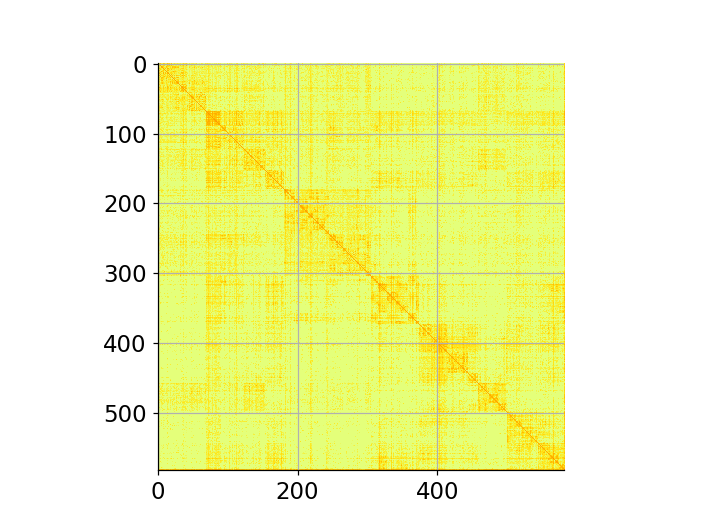

In [15]:
# logarithmic visualisation of mobility matrix
visualise_matrix(mmprox_mun)

In [16]:
# Arrondissement level

agg='arr'
mmprox_arr = mm_aggregate(mmprox_complete, agg=agg)
mmprox_arr

,11000,12000,13000,21000,23000,24000,25000,31000,32000,33000,...,73000,81000,82000,83000,84000,85000,91000,92000,93000,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11000,485030,15310,11649,3942,7322,5544,1960,3156,257,783,...,1509,153,887,1267,1188,148,1425,1294,420,6922
12000,19115,155957,7049,2825,8969,8853,1154,902,109,364,...,636,204,421,718,397,152,659,666,93,1187
13000,13822,6250,208201,1632,2971,6578,653,1161,146,235,...,1264,88,470,587,389,99,405,276,113,3127
21000,4159,2085,1508,578153,56744,6145,14055,2000,162,338,...,798,524,970,1358,1483,1059,2376,3464,743,20656
23000,8247,9293,2522,76341,377272,14152,16959,2933,204,543,...,1034,371,800,1470,1602,452,2080,3501,536,4558
24000,6771,9282,7308,8948,17551,275833,6671,2044,226,343,...,2512,219,704,918,814,243,1011,1738,239,1925
25000,1767,852,609,23569,18185,7214,307095,1280,77,203,...,346,635,899,1547,1686,881,2815,10299,887,4278
31000,1959,482,744,1093,1831,987,606,134837,979,746,...,211,54,200,512,333,165,511,380,143,1344
32000,292,76,136,139,285,106,64,1989,17387,1486,...,18,1,29,103,37,30,42,49,30,149


<IPython.core.display.Javascript object>


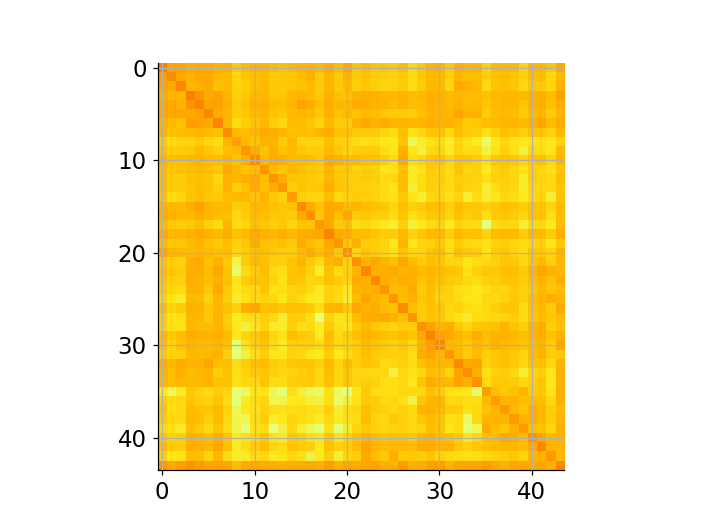

In [17]:
# logarithmic visualisation of mobility matrix
visualise_matrix(mmprox_arr)

In [18]:
# Province level

agg='prov'
mmprox_prov = mm_aggregate(mmprox_complete, agg=agg)
print_date(date)
mmprox_prov

2020 12 21


,10000,20001,20002,21000,30000,40000,50000,60000,70000,80000,90000,ABROAD
mllp_postalcode,,,,,,,,,,,,
10000,922383,40237,3767,8399,17848,29731,6014,9990,19455,7168,5351,11236
20001,43423,684808,23630,85289,18114,36334,19644,13563,21614,7593,9105,6483
20002,3228,25399,307095,23569,4190,2845,23415,10388,1604,5648,14001,4278
21000,7752,62889,14055,578153,7124,6993,13880,8493,3098,5394,6583,20656
30000,13346,12265,2480,4816,669964,40312,20654,4698,4523,4887,4016,6101
40000,35945,39764,4112,11962,45774,837076,16912,7957,6563,7945,5855,7565
50000,5061,22871,28219,18439,25420,16034,999632,12890,1791,7679,29835,15653
60000,4497,10919,9683,9063,6059,3801,13282,870874,12548,17698,20171,12274
70000,20861,22652,1595,3718,6279,6457,2611,15294,438738,2769,2193,7406


<IPython.core.display.Javascript object>


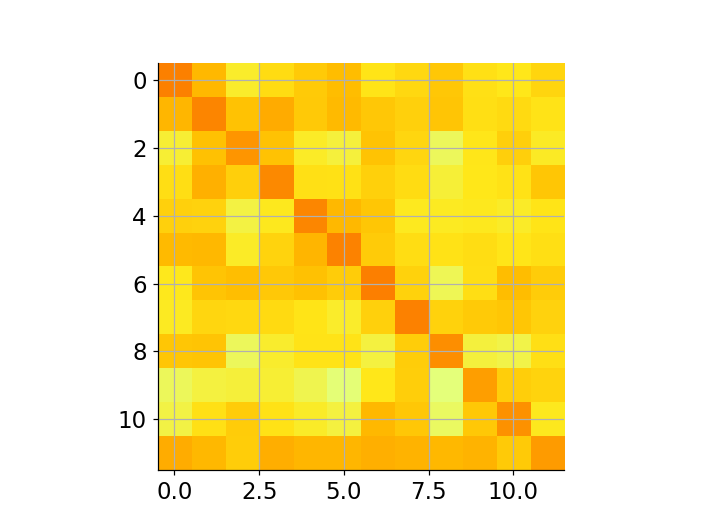

In [19]:
# logarithmic visualisation of mobility matrix
visualise_matrix(mmprox_prov)

# All-in-one solution

In [20]:
agg = 'arr'
mmprox_clean = complete_data_clean(mmprox[date], agg=agg)

# Visualisation

In [23]:
# Visualisation in geopandas
import geopandas as gp

# Load different geographical aggregations
maps_dir = '../../data/raw/geopandas/BE/'

country = gp.read_file(os.path.join(maps_dir, 'AD_6_Country.shp'))
regions = gp.read_file(os.path.join(maps_dir, 'AD_5_Region.shp'))
provinces = gp.read_file(os.path.join(maps_dir, 'AD_4_Province.shp'))
arrondissements = gp.read_file(os.path.join(maps_dir, 'AD_3_District.shp'))
municipalities = gp.read_file(os.path.join(maps_dir, 'AD_2_Municipality.shp'))

# Add NIS-code to Arrondissement Brussel-Hoofdstad
provinces.loc[provinces['NISCode']=='NA', 'NISCode'] = '21000'

# Create circle denoting foreigners
import shapely.affinity
from shapely.geometry import Point
circle = Point(570000, 600000).buffer(1)  # type(circle)=polygon
radius = 1.3e4
ellipse = shapely.affinity.scale(circle, radius, radius)  # type(ellipse)=polygon

# Add additional column to geopandas dataframes for foreigners, depicted by circle
foreign_mun = pd.DataFrame([[np.nan, np.nan, np.nan, 'Foreigner', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ellipse]], columns=municipalities.columns)
municipalities = municipalities.append(foreign_mun, ignore_index=True)

foreign_arr = pd.DataFrame([[np.nan, 'Foreigner', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ellipse]], columns=arrondissements.columns)
arrondissements = arrondissements.append(foreign_arr, ignore_index=True)

foreign_prov = pd.DataFrame([[np.nan, 'Foreigner', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ellipse]], columns=provinces.columns)
provinces = provinces.append(foreign_prov, ignore_index=True)

## Municipality level

In [24]:
# Add columns with 'traffic to' values
to_NIS = ['44021', '21004', '11002'] # Ghent, Brussels, Antwerp
# to_NIS = ['93014']

# Prepare empty columns
for nis in to_NIS:
    municipalities['Traffic to ' + nis] = 0
    
# Add value to proper column
for nis_from in municipalities['NISCode'].values:
    for nis_to in to_NIS:
        municipalities.loc[municipalities['NISCode']==nis_from,'Traffic to ' + nis_to] = mmprox_mun.loc[nis_from, nis_to]

<IPython.core.display.Javascript object>


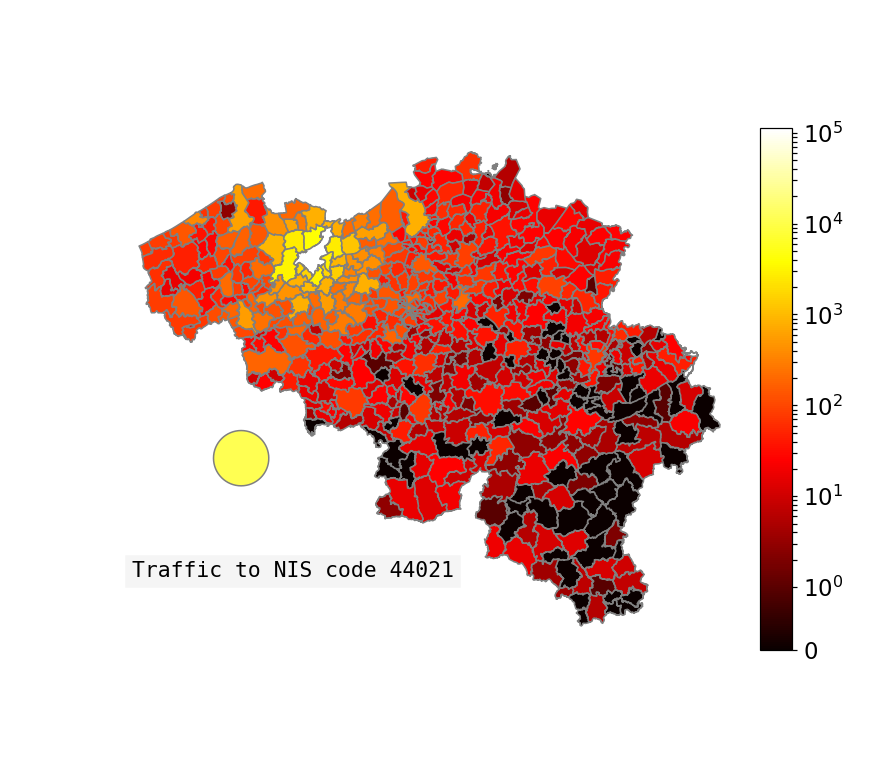

<IPython.core.display.Javascript object>


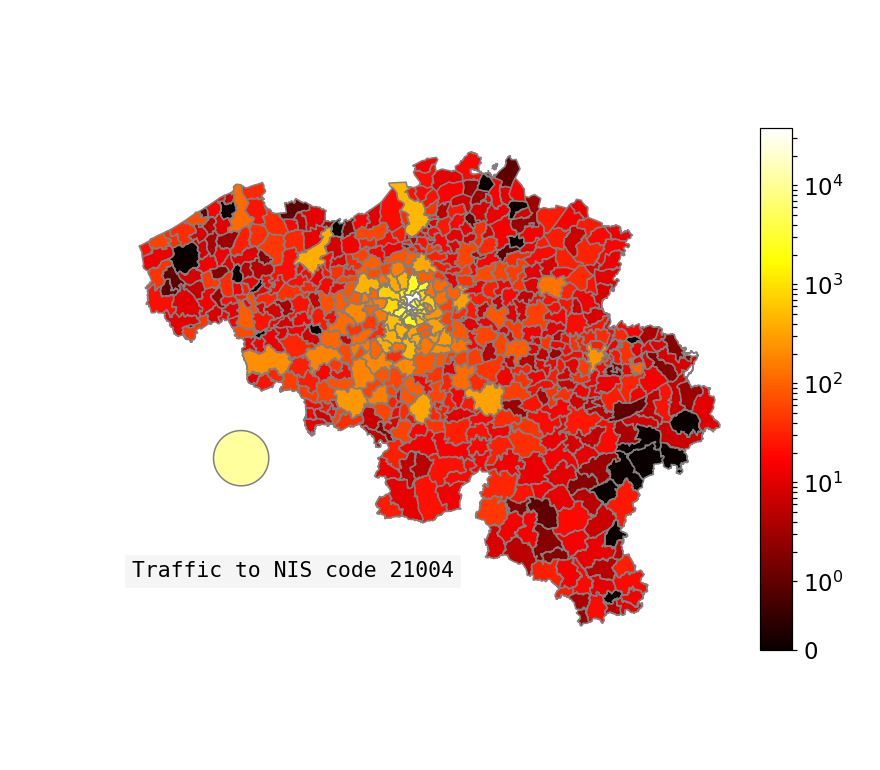

<IPython.core.display.Javascript object>


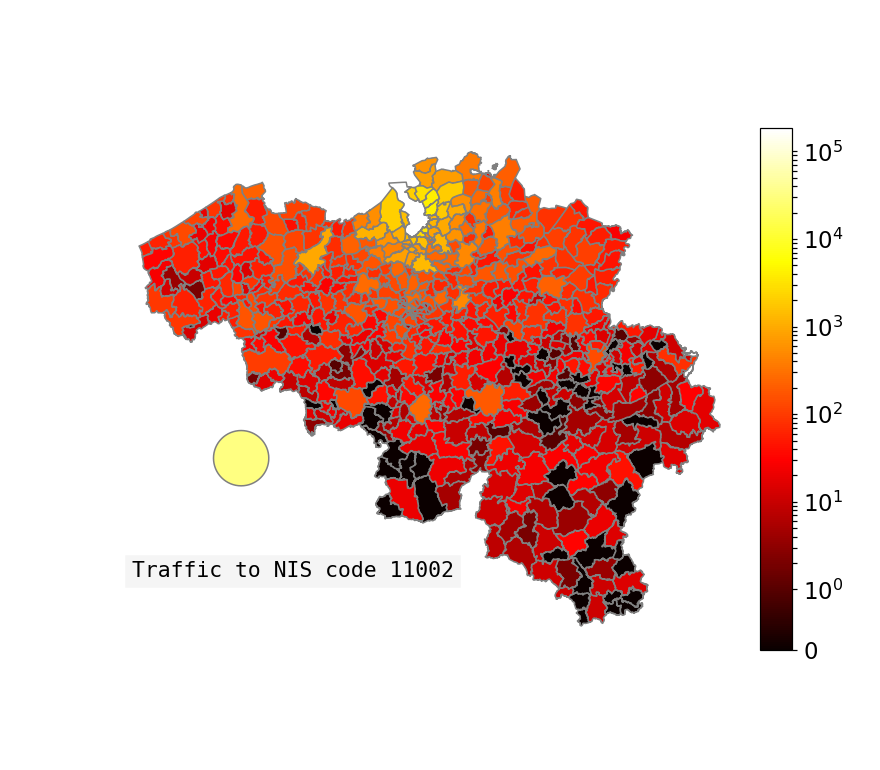

In [25]:
# Plot connections

from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics
from matplotlib import colors

for nis in to_NIS:
    # Make figure
    fig, ax = plt.subplots(figsize = (8,7)) # 1200 pixels x 1200 pixels
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
    ax.set_axis_off()
    
    vmin=0
    vmax=max(municipalities['Traffic to ' + nis])
    fig = municipalities.plot(column='Traffic to ' + nis, ax=ax, cmap='hot',
                                legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

    textbox = 'Traffic to NIS code ' + nis
    plt.figtext(.15, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
#     plt.close()

    # (Create directory and) save figure
    path = '../figures/maps/municipalities/time_series_tests/'
    chart = fig.get_figure()
    # chart.savefig('time-delays_arr_to_' + arr + '.jpg' ,dpi=50, bbox_inches='tight')

## Arrondissement level

In [26]:
# Rename columns
mmprox_arr = mmprox_mun.copy()
for nis in mmprox_arr.columns:
    if nis != 'ABROAD':
        new_nis = nis[:-3] + '000'
        mmprox_arr = mmprox_arr.rename(columns={nis : new_nis})
    
# Rename rows
for nis in mmprox_arr.index:
    if nis != 'Foreigner':
        new_nis = nis[:-3] + '000'
        mmprox_arr = mmprox_arr.rename(index={nis : new_nis})

# Collect rows and columns with the same NIS code, and automatically order column/row names
mmprox_arr = mmprox_arr.groupby(level=0, axis=0).sum()
mmprox_arr = mmprox_arr.groupby(level=0, axis=1).sum()

<IPython.core.display.Javascript object>


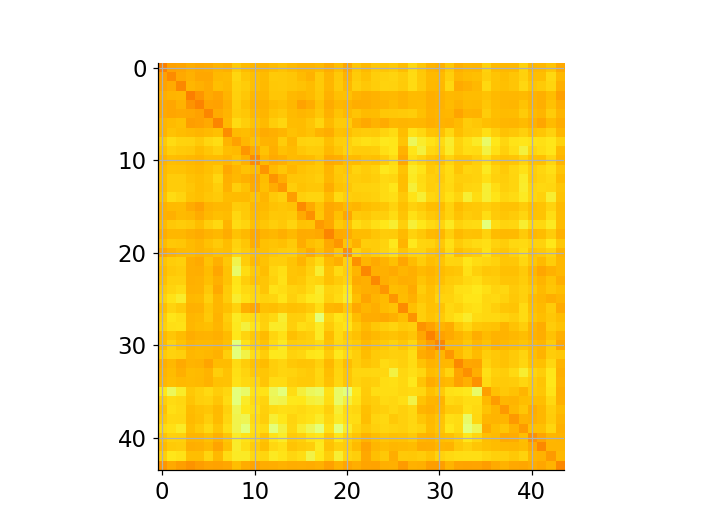

In [27]:
# Visualisation in heat plot
raw_matrix=np.log(np.array(mmprox_arr.values, dtype=float)+1)

# raw_matrix.shape

plt.imshow(raw_matrix, cmap='Wistia', interpolation=None)
plt.show()

In [28]:
# visualise in geopandas

# Add columns with 'traffic to' values
to_NIS = ['44000', '21000', '11000'] # Ghent, Brussels, Antwerp

# Prepare empty columns
for nis in to_NIS:
    arrondissements['Traffic to ' + nis] = 0
    
# Add value to proper column
for nis_from in arrondissements['NISCode'].values:
    for nis_to in to_NIS:
        arrondissements.loc[arrondissements['NISCode']==nis_from,'Traffic to ' + nis_to] = mmprox_arr.loc[nis_from, nis_to]

<IPython.core.display.Javascript object>


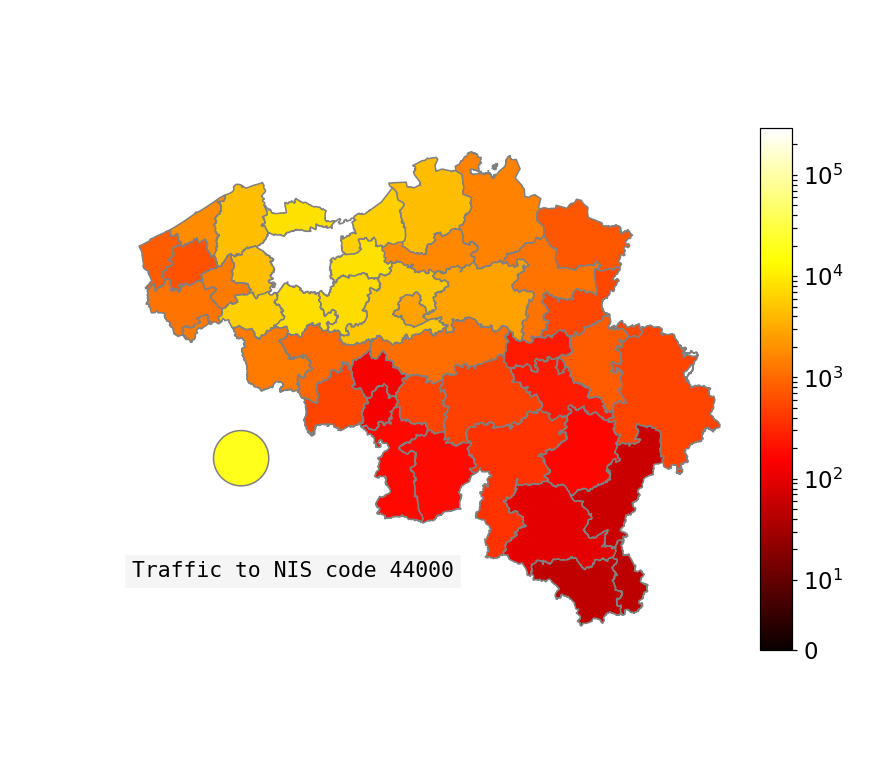

<IPython.core.display.Javascript object>


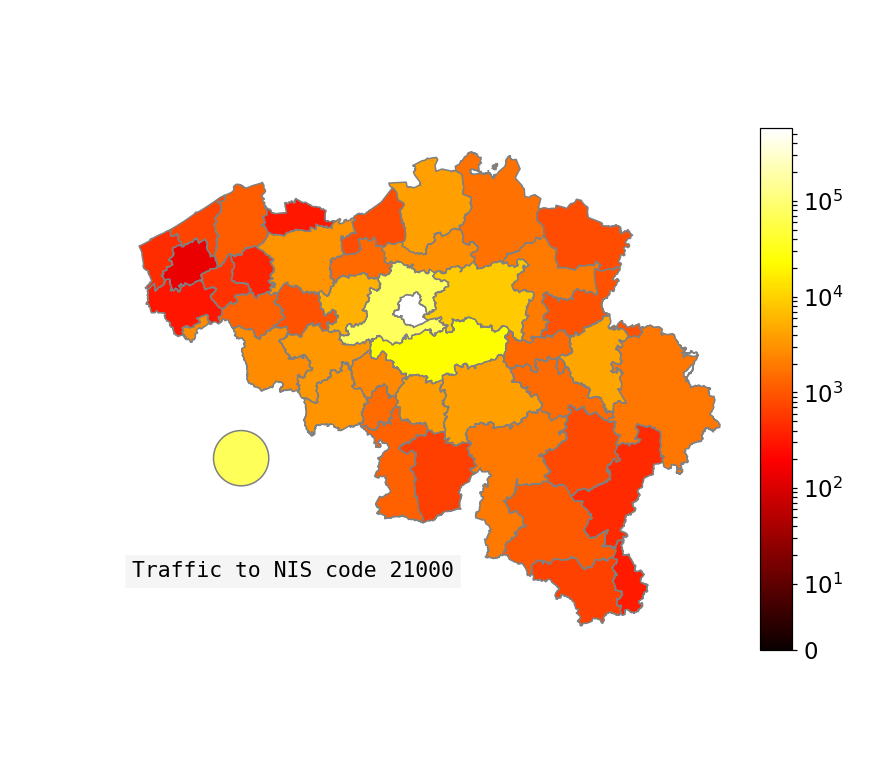

<IPython.core.display.Javascript object>


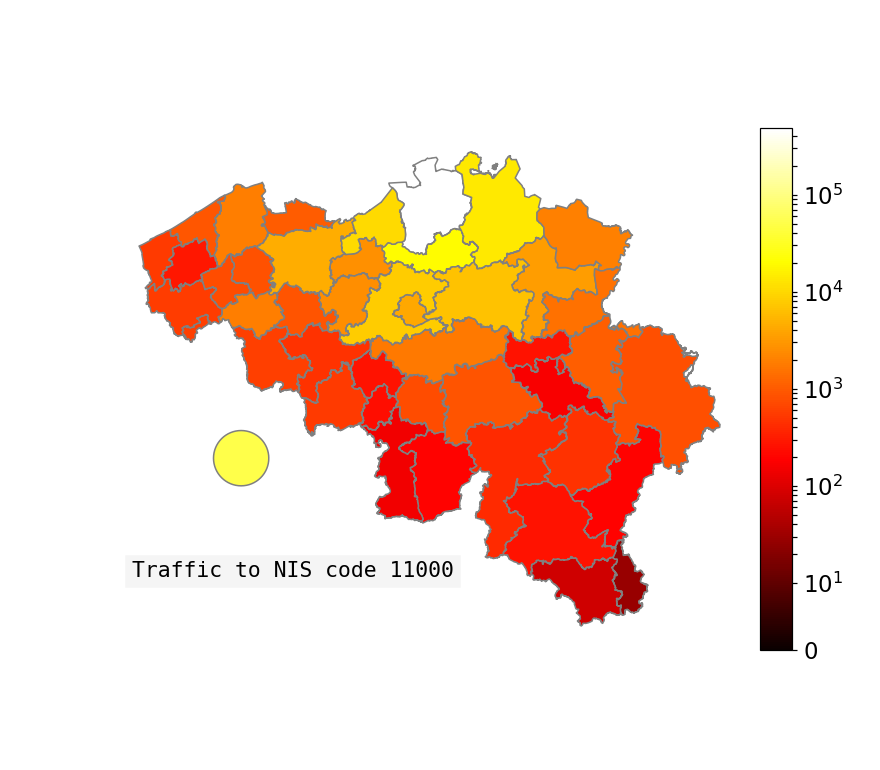

In [29]:
# Plot connections

for nis in to_NIS:
    # Make figure
    fig, ax = plt.subplots(figsize = (8,7)) # 1200 pixels x 1200 pixels
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
    ax.set_axis_off()
    
    vmin=0
    vmax=max(arrondissements['Traffic to ' + nis])
    fig = arrondissements.plot(column='Traffic to ' + nis, ax=ax, cmap='hot',
                                legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=10, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

    textbox = 'Traffic to NIS code ' + nis
    plt.figtext(.15, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
    # plt.close()

    # (Create directory and) save figure
    path = '../figures/maps/arrondissements/time_series_tests/'
    chart = fig.get_figure()
    # chart.savefig('time-delays_arr_to_' + arr + '.jpg' ,dpi=50, bbox_inches='tight')

## Province level

In [30]:
# Rename columns
mmprox_prov = mmprox_arr.copy()
for nis in mmprox_prov.columns:
    if nis not in ['ABROAD', '21000', '23000', '24000', '25000']: # Brussels is '11th province'
        new_nis = nis[:-4] + '0000'
        mmprox_prov = mmprox_prov.rename(columns={nis : new_nis})
    if nis in ['23000', '24000']:
        new_nis = '20001'
        mmprox_prov = mmprox_prov.rename(columns={nis : new_nis})
    if nis == '25000':
        new_nis = '20002'
        mmprox_prov = mmprox_prov.rename(columns={nis : new_nis})
    
# Rename rows
for nis in mmprox_prov.index:
    if nis not in ['Foreigner', '21000', '23000', '24000', '25000']:
        new_nis = nis[:-4] + '0000'
        mmprox_prov = mmprox_prov.rename(index={nis : new_nis})
    if nis in ['23000', '24000']:
        new_nis = '20001'
        mmprox_prov = mmprox_prov.rename(index={nis : new_nis})
    if nis == '25000':
        new_nis = '20002'
        mmprox_prov = mmprox_prov.rename(index={nis : new_nis})

# Collect rows and columns with the same NIS code, and automatically order column/row names
mmprox_prov = mmprox_prov.groupby(level=0, axis=0).sum()
mmprox_prov = mmprox_prov.groupby(level=0, axis=1).sum()

<IPython.core.display.Javascript object>


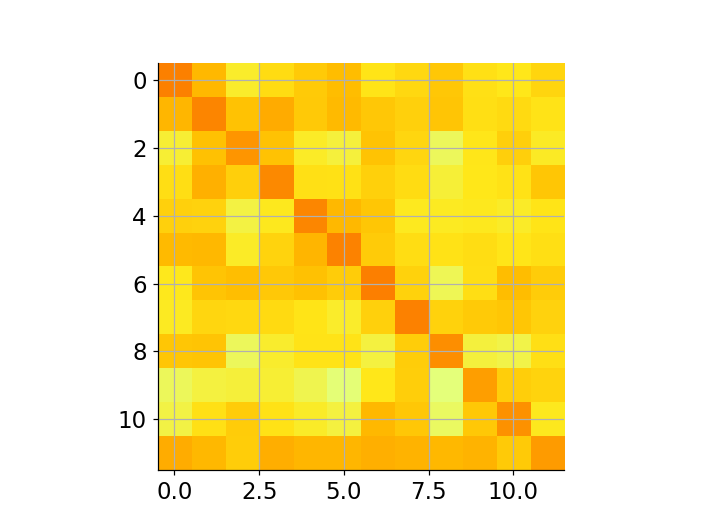

In [31]:
# Visualisation in heat plot
raw_matrix=np.log(np.array(mmprox_prov.values, dtype=float)+1)

# raw_matrix.shape

plt.imshow(raw_matrix, cmap='Wistia', interpolation=None)
plt.show()

In [32]:
# visualise in geopandas

# Add columns with 'traffic to' values
to_NIS = ['40000', '21000', '10000'] # Ghent, Brussels, Antwerp

# Prepare empty columns
for nis in to_NIS:
    provinces['Traffic to ' + nis] = 0
    
# Add value to proper column
for nis_from in provinces['NISCode'].values:
    for nis_to in to_NIS:
        provinces.loc[provinces['NISCode']==nis_from,'Traffic to ' + nis_to] = mmprox_prov.loc[nis_from, nis_to]

<IPython.core.display.Javascript object>


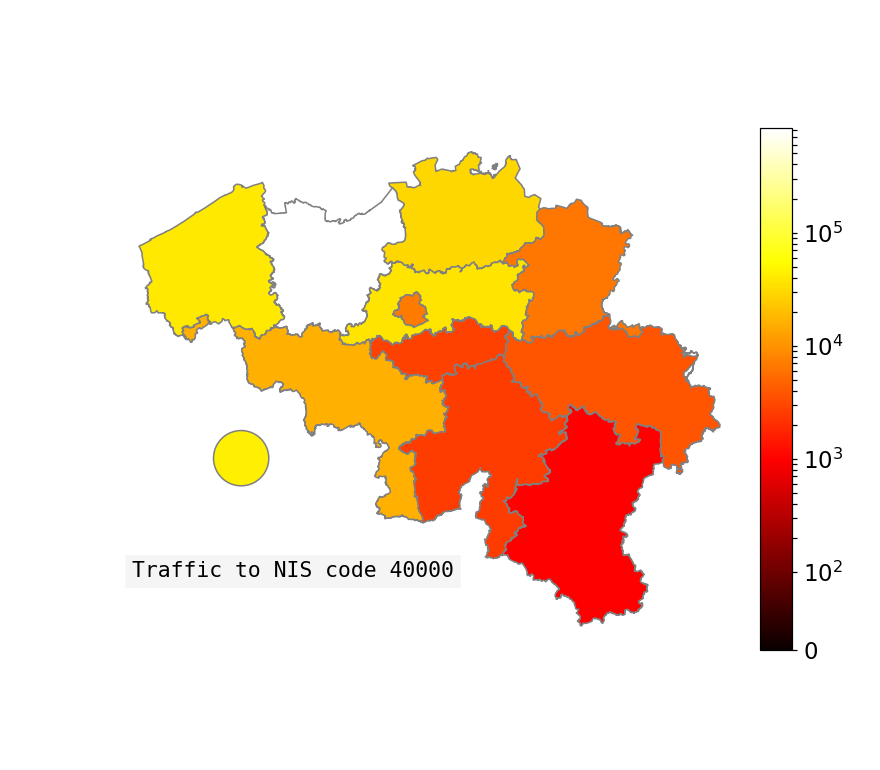

<IPython.core.display.Javascript object>


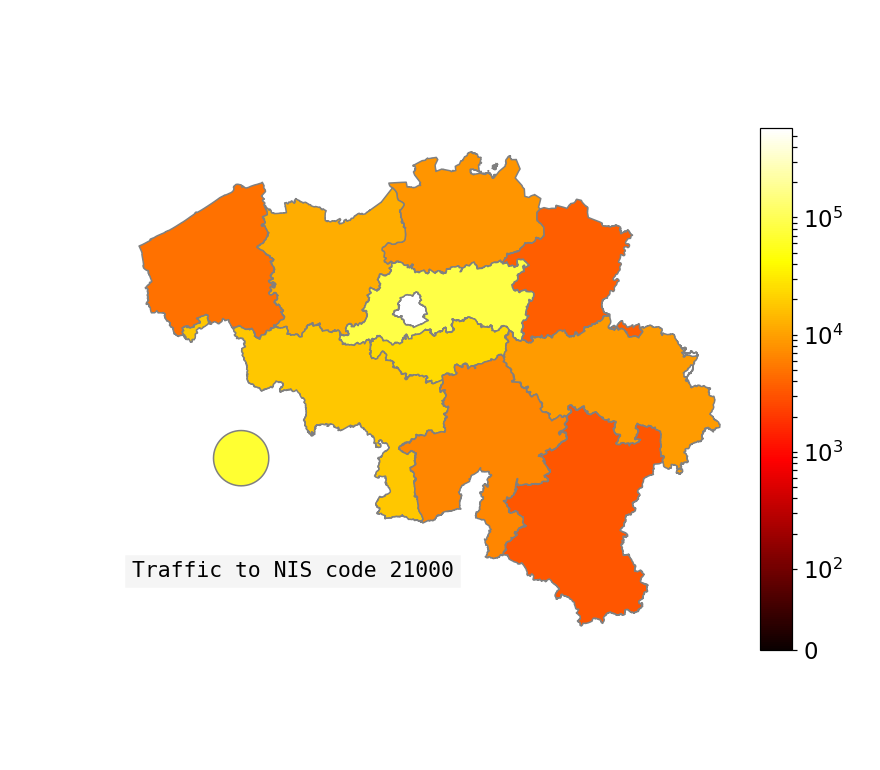

<IPython.core.display.Javascript object>


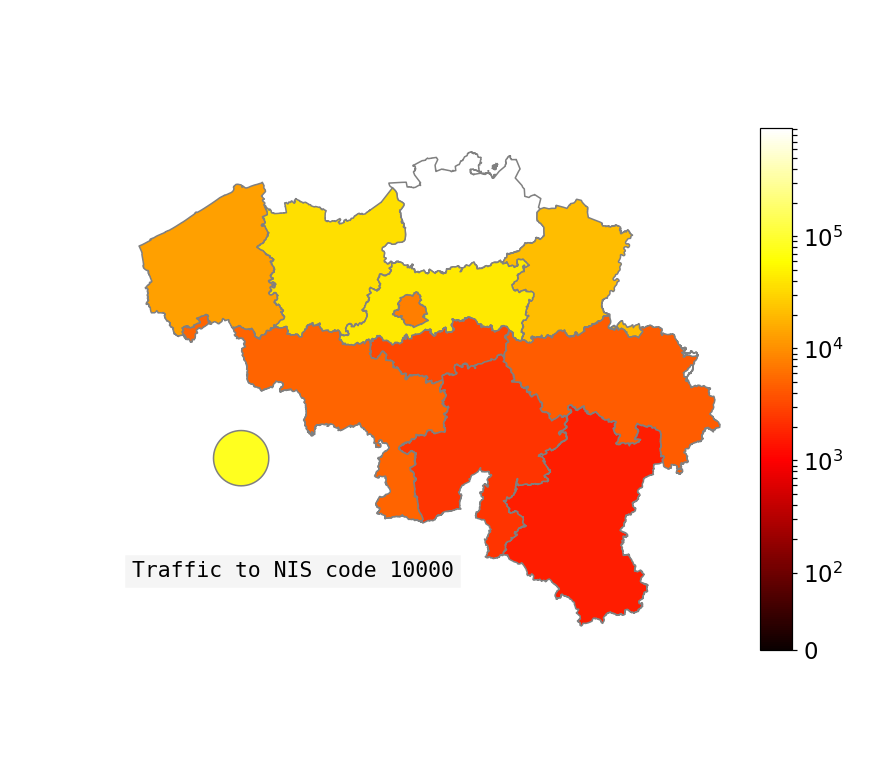

In [33]:
# Plot connections

for nis in to_NIS:
    # Make figure
    fig, ax = plt.subplots(figsize = (8,7)) # 1200 pixels x 1200 pixels
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
    ax.set_axis_off()
    
    vmin=0
    vmax=max(provinces['Traffic to ' + nis])
    fig = provinces.plot(column='Traffic to ' + nis, ax=ax, cmap='hot',
                                legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=100, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

    textbox = 'Traffic to NIS code ' + nis
    plt.figtext(.15, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
    # plt.close()

    # (Create directory and) save figure
    path = '../figures/maps/provinces/time_series_tests/'
    chart = fig.get_figure()
    # chart.savefig('time-delays_arr_to_' + arr + '.jpg' ,dpi=50, bbox_inches='tight')

## Animation (do not execute)

In [513]:
# Add columns with 'traffic to' values
to_NIS = mmprox_mun.columns

municipalities_anim = municipalities.copy()

# Prepare empty columns
for nis in to_NIS:
    municipalities_anim['Traffic to ' + nis] = 0
    
# Add value to proper column
for nis_from in municipalities_anim['NISCode'].values:
    for nis_to in to_NIS:
        municipalities_anim.loc[municipalities_anim['NISCode']==nis_from,'Traffic to ' + nis_to] = mmprox_mun.loc[nis_from, nis_to]

In [518]:
# Plot connections

from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics
from matplotlib import colors

vmin=0
vmax=np.max(np.max(mmprox_mun))
dpi=200

for nis in to_NIS:
    # Make figure
    fig, ax = plt.subplots(figsize = (8,7)) # 1200 pixels x 1200 pixels
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
    ax.set_axis_off()
    
    fig = municipalities_anim.plot(column='Traffic to ' + nis, ax=ax, cmap='hot',
                                legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

    textbox = 'Traffic to NIS code ' + nis
    plt.figtext(.15, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
    plt.close()

    # (Create directory and) save figure
    path = '../figures/maps/mun/mobility/'
    chart = fig.get_figure()
    chart.savefig(path+'mobility-to-NIS-' + nis + '.jpg' ,dpi=dpi, bbox_inches='tight')
    print("saving NIS", nis)

# Temporal aggregation

In [42]:
# TAKES A WHILE TO LOAD

### Example ###
# Select dates of the week the mobility will be averaged over
week_nr = 51
dates=make_date_list(week_nr) # [YYYYMMDD, ...]

# Load data for all these dates
location = 'C:\\Users\\mrollier\\OneDrive - UGent\\Spatial COVID personal\\Data\\Proximus\\'
mmprox = load_mobility_proximus(dates, data_location)

# Clean data for all dates
agg='mun'
for date in mmprox:
    mmprox[date] = complete_data_clean(mmprox[date], agg=agg)
    print(f"Cleaned up dataframe for date {date}")

... proceeding with 6 dates.
Loaded dataframe for date 20201216.
Loaded dataframe for date 20201220.
Loaded dataframe for date 20201219.
Loaded dataframe for date 20201214.
Loaded dataframe for date 20201217.
Loaded dataframe for date 20201215.
Cleaning up dataframe for date 20201216
Cleaning up dataframe for date 20201220
Cleaning up dataframe for date 20201219
Cleaning up dataframe for date 20201214
Cleaning up dataframe for date 20201217
Cleaning up dataframe for date 20201215


In [37]:
mmprox_avg = average_mobility(mmprox)
mmprox_avg

,11001,11002,11004,11005,11007,11008,11009,11013,11016,11018,...,92141,92142,93010,93014,93018,93022,93056,93088,93090,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11001,5419.500000,2038.666667,14.333333,514.000000,2.833333,3.500000,6.500000,212.500000,3.666667,117.500000,...,0.000000,7.500000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.333333
11002,1268.000000,224721.166667,606.666667,479.000000,1812.500000,3136.833333,649.666667,3236.666667,110.500000,768.166667,...,21.166667,65.166667,8.333333,32.833333,7.333333,18.666667,25.833333,30.333333,20.666667,3101.666667
11004,36.166667,1124.333333,5375.666667,13.000000,176.000000,10.000000,15.333333,210.833333,7.833333,11.833333,...,0.000000,1.833333,0.000000,0.166667,1.333333,0.000000,0.000000,0.166667,0.000000,59.833333
11005,583.166667,1251.666667,9.000000,6152.166667,5.500000,5.166667,5.833333,92.000000,4.166667,96.000000,...,0.000000,3.833333,5.333333,0.000000,0.000000,0.000000,0.000000,0.166667,0.500000,69.666667
11007,3.833333,1914.166667,133.833333,4.166667,2978.500000,15.333333,8.666667,45.000000,4.833333,6.166667,...,0.666667,0.833333,0.000000,0.333333,0.000000,0.000000,0.166667,0.000000,0.000000,37.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93022,0.000000,14.833333,0.000000,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,1.666667,...,19.833333,27.166667,20.666667,67.166667,50.833333,5286.666667,445.833333,631.000000,11.833333,66.333333
93056,0.000000,6.333333,0.000000,0.500000,0.000000,0.166667,0.000000,0.500000,0.000000,0.000000,...,10.000000,12.500000,123.166667,749.833333,417.000000,437.333333,4465.666667,387.833333,208.000000,208.166667
93088,6.000000,40.000000,1.000000,0.333333,0.000000,0.166667,0.333333,0.000000,0.333333,0.000000,...,17.500000,35.666667,262.500000,128.166667,16.166667,784.000000,799.666667,10436.500000,14.500000,127.666667


In [135]:
# Save the weekly average as a CSV.

# NOTE: TAKES LONG TIME AND HAS ALREADY BEEN DONE. Added here for completeness
# Uncomment to use


# location = "C:\\Users\\mrollier\\OneDrive - UGent\\Spatial COVID personal\\Data\\Proximus"

# year = 2020
# agg = 'mun'
# save_location = location + '\\mobility\\' + agg + '\\'
# save_prefix = "average-mobility_" + agg + "_" + str(year) + "-week"
# weeks = range(7,55) # week 7 is the first week with data of 2020. Week 53 is the last week of 2020

# for week in weeks:
#     # Load all data
#     dates = make_date_list(week, year)
#     mmprox_dict_tmp = load_mobility_proximus(dates, data_location)
#     for date in mmprox_dict_tmp:
#         mmprox_dict_tmp[date] = complete_data_clean(mmprox_dict_tmp[date], agg=agg)
#         print(f"Cleaned dataframe for date {date}")
#     mmprox_avg = average_mobility(mmprox_dict_tmp)
#     # Save all data
#     save_name = save_location + save_prefix + str(week)
#     mmprox_avg.to_csv(save_name)
#     print(f"Saved average of week {week}.")

Loaded dataframe for date 20200215.
Loaded dataframe for date 20200212.
Loaded dataframe for date 20200214.
Loaded dataframe for date 20200210.
Loaded dataframe for date 20200211.
Loaded dataframe for date 20200213.
Loaded dataframe for date 20200216.
Cleaned dataframe for date 20200215
Cleaned dataframe for date 20200212
Cleaned dataframe for date 20200214
Cleaned dataframe for date 20200210
Cleaned dataframe for date 20200211
Cleaned dataframe for date 20200213
Cleaned dataframe for date 20200216
Saved average of week 7.
... proceeding with 6 dates.
Loaded dataframe for date 20200218.
Loaded dataframe for date 20200219.
Loaded dataframe for date 20200222.
Loaded dataframe for date 20200217.
Loaded dataframe for date 20200223.
Loaded dataframe for date 20200220.
Cleaned dataframe for date 20200218
Cleaned dataframe for date 20200219
Cleaned dataframe for date 20200222
Cleaned dataframe for date 20200217
Cleaned dataframe for date 20200223
Cleaned dataframe for date 20200220
Saved aver

Loaded dataframe for date 20200529.
Cleaned dataframe for date 20200527
Cleaned dataframe for date 20200528
Cleaned dataframe for date 20200526
Cleaned dataframe for date 20200530
Cleaned dataframe for date 20200531
Cleaned dataframe for date 20200525
Cleaned dataframe for date 20200529
Saved average of week 22.
Loaded dataframe for date 20200601.
Loaded dataframe for date 20200607.
Loaded dataframe for date 20200603.
Loaded dataframe for date 20200604.
Loaded dataframe for date 20200606.
Loaded dataframe for date 20200602.
Loaded dataframe for date 20200605.
Cleaned dataframe for date 20200601
Cleaned dataframe for date 20200607
Cleaned dataframe for date 20200603
Cleaned dataframe for date 20200604
Cleaned dataframe for date 20200606
Cleaned dataframe for date 20200602
Cleaned dataframe for date 20200605
Saved average of week 23.
Loaded dataframe for date 20200614.
Loaded dataframe for date 20200612.
Loaded dataframe for date 20200608.
Loaded dataframe for date 20200611.
Loaded dataf

Cleaned dataframe for date 20200908
Saved average of week 37.
Loaded dataframe for date 20200916.
Loaded dataframe for date 20200918.
Loaded dataframe for date 20200914.
Loaded dataframe for date 20200917.
Loaded dataframe for date 20200915.
Loaded dataframe for date 20200920.
Loaded dataframe for date 20200919.
Cleaned dataframe for date 20200916
Cleaned dataframe for date 20200918
Cleaned dataframe for date 20200914
Cleaned dataframe for date 20200917
Cleaned dataframe for date 20200915
Cleaned dataframe for date 20200920
Cleaned dataframe for date 20200919
Saved average of week 38.
Loaded dataframe for date 20200924.
Loaded dataframe for date 20200921.
Loaded dataframe for date 20200927.
Loaded dataframe for date 20200923.
Loaded dataframe for date 20200925.
Loaded dataframe for date 20200926.
Loaded dataframe for date 20200922.
Cleaned dataframe for date 20200924
Cleaned dataframe for date 20200921
Cleaned dataframe for date 20200927
Cleaned dataframe for date 20200923
Cleaned data

Loaded dataframe for date 20201228.
Loaded dataframe for date 20201229.
Loaded dataframe for date 20210101.
Cleaned dataframe for date 20210103
Cleaned dataframe for date 20210102
Cleaned dataframe for date 20201230
Cleaned dataframe for date 20201231
Cleaned dataframe for date 20201228
Cleaned dataframe for date 20201229
Cleaned dataframe for date 20210101
Saved average of week 53.
... proceeding with 4 dates.
Loaded dataframe for date 20210104.
Loaded dataframe for date 20210105.
Loaded dataframe for date 20210106.
Loaded dataframe for date 20210107.
Cleaned dataframe for date 20210104
Cleaned dataframe for date 20210105
Cleaned dataframe for date 20210106
Cleaned dataframe for date 20210107
Saved average of week 54.


In [43]:
# Aggregate on arr and prov level
# Definitions

def agg_mun_to_arr(mmprox_mun): # copied from mm_aggregate function
    # Rename columns
    mmprox_arr = mmprox_mun.copy()
    for nis in mmprox_arr.columns:
        if nis != 'ABROAD':
            new_nis = nis[:-3] + '000'
            mmprox_arr = mmprox_arr.rename(columns={nis : new_nis})

    # Rename rows
    for nis in mmprox_arr.index:
        if nis != 'Foreigner':
            new_nis = nis[:-3] + '000'
            mmprox_arr = mmprox_arr.rename(index={nis : new_nis})

    # Collect rows and columns with the same NIS code, and automatically order column/row names
    mmprox_arr = mmprox_arr.groupby(level=0, axis=1).sum()
    mmprox_arr = mmprox_arr.groupby(level=0, axis=0).sum().astype(int)
    
    return mmprox_arr

def agg_arr_to_prov(mmprox_arr):
    # Rename columns
    mmprox_prov = mmprox_arr.copy()
    for nis in mmprox_arr.columns:
        if nis not in ['ABROAD', '21000', '23000', '24000', '25000']: # Brussels is '11th province'
            new_nis = nis[:-4] + '0000'
            mmprox_prov = mmprox_prov.rename(columns={nis : new_nis})
        if nis in ['23000', '24000']:
            new_nis = '20001'
            mmprox_prov = mmprox_prov.rename(columns={nis : new_nis})
        if nis == '25000':
            new_nis = '20002'
            mmprox_prov = mmprox_prov.rename(columns={nis : new_nis})

    # Rename rows
    for nis in mmprox_prov.index:
        if nis not in ['Foreigner', '21000', '23000', '24000', '25000']:
            new_nis = nis[:-4] + '0000'
            mmprox_prov = mmprox_prov.rename(index={nis : new_nis})
        if nis in ['23000', '24000']:
            new_nis = '20001'
            mmprox_prov = mmprox_prov.rename(index={nis : new_nis})
        if nis == '25000':
            new_nis = '20002'
            mmprox_prov = mmprox_prov.rename(index={nis : new_nis})

    # Collect rows and columns with the same NIS code, and automatically order column/row names
    mmprox_prov = mmprox_prov.groupby(level=0, axis=1).sum()
    mmprox_prov = mmprox_prov.groupby(level=0, axis=0).sum().astype(int)
    
    return mmprox_prov

In [171]:
# Save the weekly average of arrondissements as a CSV.

# THIS HAS ALREADY BEEN DONE. Uncomment to use

# year = 2020
# save_agg = 'arr'
# load_agg = 'mun'
# save_location = #PICK LOCATION
# save_prefix = "average-mobility_" + save_agg + "_" + str(year) + "-week"

# weeks = range(7,54) # week 7 is the first week with data. Week 53 is the last week of 2020

# for week in weeks:
#     # Load CSV
#     mmprox_mun = load_avg_mobility(week, year=year, agg=load_agg)
#     # Aggregate to higher level
#     mmprox_arr = agg_mun_to_arr(mmprox_mun)
#     # Save in proper location
#     save_name = save_location + save_prefix + str(week)
#     mmprox_arr.to_csv(save_name)
#     print(f"Saved arrondissement average of week {week}.  ", end='\r')

In [190]:
# Save the weekly average of provinces as a CSV.

# THIS HAS ALREADY BEEN DONE. Uncomment to use

# year = 2020
# save_agg = 'prov'
# load_agg = 'arr'
# save_location = #PICK LOCATION
# save_prefix = "average-mobility_" + save_agg + "_" + str(year) + "-week"

# weeks = range(7,54) # week 7 is the first week with data. Week 53 is the last week of 2020

# for week in weeks:
#     # Load CSV
#     mmprox_arr = load_avg_mobility(week, year=year, agg=load_agg)
#     # Aggregate to higher level
#     mmprox_prov = agg_arr_to_prov(mmprox_arr)
#     # Save in proper location
#     save_name = save_location + save_prefix + str(week)
#     mmprox_prov.to_csv(save_name)
#     print(f"Saved provincial average of week {week}.  ", end='\r')

In [81]:
# Load the weekly average in the proper way (test)
# Customise this to your needs!

load_location_base = "../../data/interim/mobility/"

def load_avg_mobility(week, year=2020, agg='mun'):
    load_location = load_location_base + agg + "/"
    load_prefix = "average-mobility_" + agg + '_' + str(year) + "-week"
    load_name = load_location + load_prefix + str(week)
    index_col = 'mllp_postalcode'
    mmprox_avg = pd.read_csv(load_name, index_col=index_col)
    return mmprox_avg

week = 7
agg = 'mun'
mmprox_loaded = load_avg_mobility(week, agg=agg)

mmprox_loaded

,11001,11002,11004,11005,11007,11008,11009,11013,11016,11018,...,92141,92142,93010,93014,93018,93022,93056,93088,93090,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11001,4930.142857,2632.285714,38.857143,557.000000,3.000000,18.000000,3.714286,269.714286,2.428571,126.428571,...,2.142857,3.000000,0.000000,0.428571,1.285714,0.857143,4.714286,1.000000,0.000000,23.285714
11002,1476.000000,240587.714286,859.000000,566.714286,2120.428571,3638.857143,771.714286,3711.142857,101.714286,860.571429,...,14.142857,81.142857,11.142857,25.571429,11.714286,11.714286,24.000000,15.714286,21.857143,700.857143
11004,42.571429,1828.428571,5156.714286,18.857143,217.857143,18.571429,5.857143,270.142857,4.857143,11.285714,...,1.428571,4.857143,0.000000,0.571429,0.000000,0.000000,2.714286,0.000000,0.285714,18.714286
11005,613.857143,1853.571429,11.000000,5876.571429,4.714286,7.000000,3.857143,144.428571,7.285714,110.000000,...,0.000000,1.285714,0.000000,0.000000,0.000000,6.428571,0.428571,0.000000,0.142857,19.714286
11007,7.428571,2633.142857,196.000000,4.857143,2959.428571,12.714286,5.000000,67.571429,4.571429,5.571429,...,0.000000,0.714286,0.571429,0.142857,0.000000,0.000000,1.285714,0.000000,0.000000,10.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93022,0.000000,16.714286,0.000000,0.142857,0.000000,0.571429,2.142857,0.000000,0.000000,0.000000,...,26.857143,27.571429,30.428571,73.285714,38.428571,5099.571429,517.714286,633.285714,20.428571,8.857143
93056,0.000000,23.857143,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000,0.000000,2.000000,...,8.857143,14.571429,151.428571,759.285714,392.142857,464.285714,4236.714286,398.714286,240.714286,23.142857
93088,0.714286,49.000000,0.000000,2.000000,0.000000,0.428571,0.285714,7.428571,0.714286,0.000000,...,19.000000,27.428571,330.428571,160.571429,14.571429,835.000000,888.857143,10006.142857,20.857143,21.571429


# Temporal visualisation

<IPython.core.display.Javascript object>


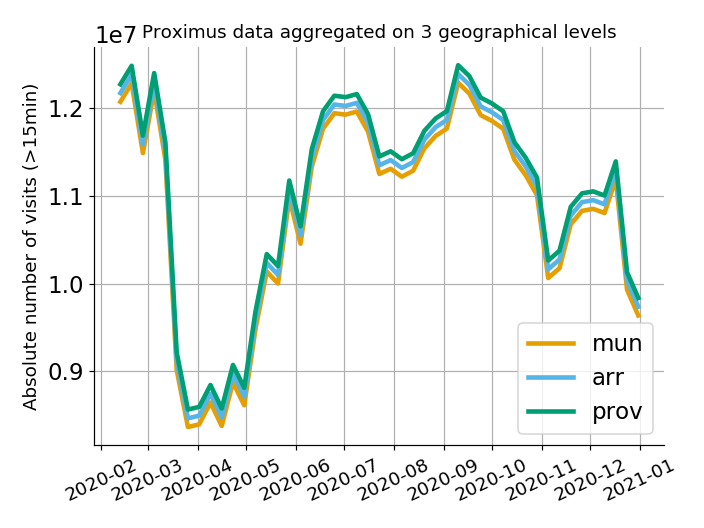

In [50]:
# All aggregations are identical: good sanity check.

year=2020
aggs=['mun', 'arr', 'prov']
weeks=np.arange(7,54)
offset=1e5
fontsize=12


figure=plt.figure()
for idx, agg in enumerate(aggs):
    dates=[]
    total_mob=[]
    for week in weeks:
        date = week_to_date(week, day=4) # day=4 for middle of week
        dates.append(date)
        total_mob_weekly = load_avg_mobility(week, year=year, agg=agg).sum().sum()
        total_mob.append(total_mob_weekly + idx*offset)
    plt.plot(dates, total_mob, label=agg)
    
plt.title('Proximus data aggregated on 3 geographical levels', fontsize=fontsize)
plt.ylabel('Absolute number of visits (>15min)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.legend()
figure.autofmt_xdate(bottom=.2, rotation=25, ha='center', which=None) # Automatic x-tick fix!
figure.tight_layout()

In [54]:
# moving average definition copied here because I couldn't find its definition on this master (?)
def moving_avg(timeseries, days=7, dropna=False, win_type=None, params=None):
    """Takes a centred moving average of a time series over a window with user-defined width and shape. Note: when taking a N-day centred moving average, the first and last N//2 days won't return a value and are effectively lost, BUT they are returned as nans. Also note that the moving average applied over missing data will result in an effectively larger window - try to make sure there is no missing data in the range the data is averaged.
    
    Parameters
    ----------
    timeseries : pandas.DataFrame
        Pandas DataFrame with chronologically ordered datetime objects as indices and a single column with float values
    days : int
        Width of the averaging window in days. Resulting value is recorded in the centre of the window. 7 days by default. If the number is uneven, the window is asymmetric toward the past.
    dropnan : boolean
        If True: only return dates that have an averaged value - i.e. drop some values at the start and the end.
    win_type : str
        Type of window, determining the weight of the values in the window. Choice between 'boxcar', 'triang', 'blackman', 'hamming', 'bartlett', 'parzen', 'bohman', 'blackmanharris', 'nuttall', 'barthann', 'kaiser' (needs parameter: beta), 'gaussian' (needs parameter: std), 'general_gaussian' (needs parameters: power, width), 'slepian' (needs parameter: width), 'exponential' (needs parameter: tau). If win_type=None (default) all points are evenly weighted.
    params : float or list of floats
        Parameters values used in some window types. 'kaiser': beta, 'gaussian': std, 'general_gaussian': [power, width], 'slepian': width, 'exponential': tau
        
    Returns
    ------
    timeseries_avg : pandas.DataFrame
        Pandas DataFrame with chronologically ordered datetime objects as indices and single column with moving-averaged float values
        
    TO DO
    -----
    Different win_types are not yet supported, because combining a non-integer window (such as '7D') cannot be combined with non-equal weighing. This can be worked around by first converting the datetime indices to regular indices, saving the datetime indices in a list, then applying centred moving average, and linking the resulting list back to the original dates.
    """
    col_name = timeseries.columns[0]
    ts_temp = pd.DataFrame(data=timeseries.values.copy())
    if win_type in [None, 'boxcar', 'triang', 'blackman', 'hamming', 'bartlett', 'parzen', 'bohman', 'blackmanharris', 'nuttall', 'barthann']:
        ts_temp = ts_temp.rolling(window=days, center=True, win_type=win_type).mean()
    params = [params]
    if win_type == 'kaiser':
        ts_temp = ts_temp.rolling(window=days, center=True, win_type=win_type).mean(beta=params[0])
    if win_type == 'gaussian':
        ts_temp = ts_temp.rolling(window=days, center=True, win_type=win_type).mean(std=params[0])
    if win_type == 'general_gaussian':
        ts_temp = ts_temp.rolling(window=days, center=True, win_type=win_type).mean(power=params[0], width=params[1])
    if win_type == 'slepian':
        ts_temp = ts_temp.rolling(window=days, center=True, win_type=win_type).mean(width=params[0])
    if win_type == 'exponential':
        ts_temp = ts_temp.rolling(window=days, center=True, win_type=win_type).mean(tau=params[0])
    
    timeseries_avg = pd.DataFrame(data=ts_temp.values.copy(), index=timeseries.index.copy(), columns=[col_name])
    if dropna:
        timeseries_avg.dropna(inplace=True)
    return timeseries_avg

<IPython.core.display.Javascript object>


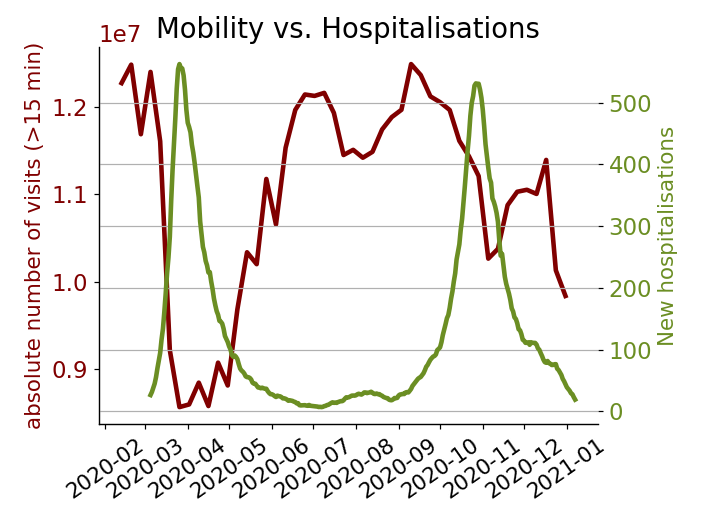

In [78]:
# Overlay total mobility over hospitalisation data

fontsize=14
agg_type = 'prov'

# NOTE: DATA TAKEN FROM PRIVATE SCIENSANO DATASET
data_file = '../../../COVID19_spatial_private/interim/all_nonpublic_timeseries_' + agg_type + '.csv'

# Load and copy the data file
raw_data = pd.read_csv(data_file, sep=',', header=0,  parse_dates = ['DATE'])
raw_data.fillna(0, inplace=True)

# select and average data
hosp_data = raw_data[['DATE','hospitalised_IN']].groupby(['DATE']).sum()
hosp_data = moving_avg(hosp_data)
hosp_indices = hosp_data.index.values
hosp_values = hosp_data['hospitalised_IN'].values


fig, ax1 = plt.subplots()
ax1.grid(False)

color = 'maroon'
# ax1.set_xlabel('date')
ax1.set_ylabel('absolute number of visits (>15 min)', color=color, fontsize=fontsize)
ax1.plot(dates, total_mob, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelsize=fontsize)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.grid(False)

color = 'olivedrab'
ax2.set_ylabel('New hospitalisations', color=color, fontsize=fontsize)  # we already handled the x-label with ax1
ax2.plot(hosp_indices, hosp_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='x', labelsize=fontsize)

fig.autofmt_xdate(bottom=.2, rotation=35, ha='center', which=None) # Automatic x-tick fix!
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Mobility vs. Hospitalisations', fontsize=fontsize+4)
plt.show()



# figure=plt.figure()
# plt.plot(data.groupby(['DATE']).sum())
# figure.autofmt_xdate(bottom=.2, rotation=25, ha='center', which=None) # Automatic x-tick fix!
# # plt.xticks(rotation=30)
# figure.tight_layout()